In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import ReconstructionLoss, TemporalLoss, SingleVisLoss, DummyTemporalLoss
from singleVis.backend import convert_distance_to_probability, compute_cross_entropy
from singleVis.edge_dataset import VisDataHandler
from singleVis.trainer import BaseTextTrainer
from singleVis.eval.evaluator import Evaluator
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import SingleEpochTextSpatialEdgeConstructor

from singleVis.projector import VISProjector
from singleVis.utils import find_neighbor_preserving_rate

/home/yiming/anaconda3/envs/visualizer/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch import nn
class UmapLoss(nn.Module):
    def __init__(self, negative_sample_rate, device, _a=1.0, _b=1.0, repulsion_strength=1.0):
        super(UmapLoss, self).__init__()

        self._negative_sample_rate = negative_sample_rate
        self._a = _a,
        self._b = _b,
        self._repulsion_strength = repulsion_strength
        self.DEVICE = torch.device(device)

    @property
    def a(self):
        return self._a[0]

    @property
    def b(self):
        return self._b[0]

    def forward(self, embedding_to, embedding_from, probs):
        # get negative samples
        batch_size = embedding_to.shape[0]
        embedding_neg_to = torch.repeat_interleave(embedding_to, self._negative_sample_rate, dim=0)
        repeat_neg = torch.repeat_interleave(embedding_from, self._negative_sample_rate, dim=0)
        randperm = torch.randperm(repeat_neg.shape[0])
        embedding_neg_from = repeat_neg[randperm]
        neg_num = len(embedding_neg_from)

        positive_distance = torch.norm(embedding_to - embedding_from, dim=1)
        negative_distance = torch.norm(embedding_neg_to - embedding_neg_from, dim=1)

        distance_embedding = torch.cat(
            (
                positive_distance,
                negative_distance,
            ),
            dim=0,
        )
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, self.a, self.b
        )
        probabilities_distance = probabilities_distance.to(self.DEVICE)

        probabilities_graph = torch.cat(
            (torch.ones(batch_size).to(self.DEVICE), torch.zeros(neg_num).to(self.DEVICE)), dim=0,
        )

        # probabilities_graph = torch.cat(
        #     (probs.to(self.DEVICE), torch.zeros(neg_num).to(self.DEVICE)), dim=0,
        # )

        probabilities_graph = probabilities_graph.to(device=self.DEVICE)

        # compute cross entropy
        (_, _, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=self._repulsion_strength,
        )   

        return torch.mean(ce_loss)

class DVILoss(nn.Module):
    def __init__(self, umap_loss, recon_loss, temporal_loss, lambd1, lambd2, device):
        super(DVILoss, self).__init__()
        self.umap_loss = umap_loss
        self.recon_loss = recon_loss
        self.temporal_loss = temporal_loss
        self.lambd1 = lambd1
        self.lambd2 = lambd2
        self.device = device

    def forward(self, edge_to, edge_from, a_to, a_from, curr_model,probs):
      
        outputs = curr_model( edge_to, edge_from)
        embedding_to, embedding_from = outputs["umap"]
        recon_to, recon_from = outputs["recon"]

        recon_l = self.recon_loss(edge_to, edge_from, recon_to, recon_from, a_to, a_from).to(self.device)
        umap_l = self.umap_loss(embedding_to, embedding_from, probs)
        temporal_l = self.temporal_loss(curr_model).to(self.device)

        loss = umap_l + self.lambd1 * recon_l + self.lambd2 * temporal_l

        return umap_l, umap_l, self.lambd1 *recon_l, self.lambd2 *temporal_l, loss

In [4]:
import re
import numpy as np

def remove_docstrings(code):
    # 使用正则表达式匹配被 """ 包括的部分，并替换为空字符串
    cleaned_code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    cleaned_code = re.sub(r"'''.*?'''", '', cleaned_code, flags=re.DOTALL)
    return cleaned_code

def cosine_similarity_matrix(nl_features, code_features):
    # 计算每个特征向量的范数
    nl_norms = np.linalg.norm(nl_features, axis=1, keepdims=True)
    code_norms = np.linalg.norm(code_features, axis=1, keepdims=True)
    
    # 计算点积
    dot_product = np.dot(nl_features, code_features.T)
    
    # 计算余弦相似度矩阵
    cosine_similarity = dot_product / (nl_norms * code_norms.T)
    
    return cosine_similarity

In [5]:
def remove_padding_intervals(tokenized_id_data):
    """
    移除 tokenized_id_data 中所有 `[0,0]` 区间（除非它是开头的第一个区间）。

    Args:
    - tokenized_id_data (list of lists): 包含区间的列表，每个区间是一个长度为 2 的列表。

    Returns:
    - filtered_data (list of lists): 移除 `[0,0]` 填充数据后的区间列表。
    """
    if isinstance(tokenized_id_data, np.ndarray):
        tokenized_id_data = tokenized_id_data.tolist()  # 将 NumPy 数组转换为列表
    # 处理的结果列表
    filtered_data = []

    # 保留开头的 `[0,0]` 区间（如果存在）
    if tokenized_id_data and tokenized_id_data[0] == [0,0]:
        filtered_data.append([0,0])
        start_index = 1  # 从第二个元素开始检查
    else:
        start_index = 0

    # 处理剩余的区间
    for interval in tokenized_id_data[start_index:]:
        if interval != [0,0]:  # 仅添加非 `[0,0]` 区间
            filtered_data.append(interval)

    return filtered_data

In [6]:
import json
def load_loss_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return np.array(data)

In [7]:
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/train.jsonl", "r") as f:
    train_dataset = [json.loads(line) for line in f.readlines()]


In [8]:
import json
input_path = "/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/sorted_labelling_sample_api_student_conf_sorted.jsonl"
idx_list = []
match_list = []

with open(input_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip().rstrip(',')  # 去除行末的逗号
        json_obj = json.loads(line)
        idx_list.append(json_obj['idx'])
        match_list.append(json_obj['match'])

In [9]:
import json
import os

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/tokenized_code_tokens_train.json'

# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    code_tokens_data = json.load(f)

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/tokenized_comment_tokens_train.json'


# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    nl_tokens_data = json.load(f)

In [10]:
# 文件路径
nl_cls_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs_cls/Epoch_{i}/train_nl_cls_tokens.npy' for i in range(1,51)]
code_cls_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs_cls/Epoch_{i}/train_code_cls_tokens.npy' for i in range(1,51)]

# 读取nl cls tokens
nl_cls_tokens = []
for path in nl_cls_paths:
    nl_cls_tokens.append(np.load(path))

# 读取code cls tokens
code_cls_tokens = []
for path in code_cls_paths:
    code_cls_tokens.append(np.load(path))


In [11]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model/code_labels/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 遍历code_cls_tokens的每一项
for i in range(len(code_cls_tokens[0])):
    # 获取原始数据集中的索引
    orig_idx = idx_list[i]

    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 从原始训练数据集中获取code项并写入文件
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        code_str = train_dataset[orig_idx]['code']
        f_out.write(f"{i}: {code_str}")

print("处理完成！")

处理完成！


In [12]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model/comment_labels/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 遍历nl_cls_tokens的每一项
for i in range(len(nl_cls_tokens[0])):
    # 获取原始数据集中的索引
    orig_idx = idx_list[i]

    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 从原始训练数据集中获取nl项并写入文件
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        nl_str = train_dataset[orig_idx]['docstring']
        f_out.write(f"{i}: {nl_str}")

print("处理完成！")

处理完成！


In [13]:
# 对每个epoch分别处理
for epoch in range(1, 51):
    # 读取当前epoch的nl_tokens和code_tokens
    nl_tokens = nl_cls_tokens[epoch-1]
    code_tokens = code_cls_tokens[epoch-1]
    
    # 拼接两部分数据
    combined_data = np.concatenate((nl_tokens, code_tokens))
    print(f"Epoch {epoch} data shape:", combined_data.shape)
    
    # 检查并创建保存目录
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 保存到对应epoch的目录
    output_path = os.path.join(output_dir, 'train_data.npy')
    np.save(output_path, combined_data)
    # print(f"Epoch {epoch} 数据已保存到 {output_path}")


Epoch 1 data shape: (11442, 768)
Epoch 2 data shape: (11442, 768)
Epoch 3 data shape: (11442, 768)
Epoch 4 data shape: (11442, 768)
Epoch 5 data shape: (11442, 768)
Epoch 6 data shape: (11442, 768)
Epoch 7 data shape: (11442, 768)
Epoch 8 data shape: (11442, 768)
Epoch 9 data shape: (11442, 768)
Epoch 10 data shape: (11442, 768)
Epoch 11 data shape: (11442, 768)
Epoch 12 data shape: (11442, 768)
Epoch 13 data shape: (11442, 768)
Epoch 14 data shape: (11442, 768)
Epoch 15 data shape: (11442, 768)
Epoch 16 data shape: (11442, 768)
Epoch 17 data shape: (11442, 768)
Epoch 18 data shape: (11442, 768)
Epoch 19 data shape: (11442, 768)
Epoch 20 data shape: (11442, 768)
Epoch 21 data shape: (11442, 768)
Epoch 22 data shape: (11442, 768)
Epoch 23 data shape: (11442, 768)
Epoch 24 data shape: (11442, 768)
Epoch 25 data shape: (11442, 768)
Epoch 26 data shape: (11442, 768)
Epoch 27 data shape: (11442, 768)
Epoch 28 data shape: (11442, 768)
Epoch 29 data shape: (11442, 768)
Epoch 30 data shape: (1

In [14]:
import json

# 生成从0到m-1的索引
indices = list(range(len(code_cls_tokens[0])))

# 为每个epoch创建并保存索引
for epoch in range(1, 51):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    index_output_path = os.path.join(output_dir, 'code_index.json')
    
    # 将索引保存到index.json中
    with open(index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {index_output_path}")


In [15]:
# 生成从0到n-1的索引
indices = list(range(len(nl_cls_tokens[0])))

# 为每个epoch创建并保存索引
for epoch in range(1, 51):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data_index_output_path = os.path.join(output_dir, 'comment_index.json')
    
    # 将索引保存到data_index.json中
    with open(data_index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {data_index_output_path}")

In [16]:
# 生成从0到n+m-1的索引
indices = list(range(len(combined_data)))

# 为每个epoch创建并保存索引
for epoch in range(1, 51):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    index_output_path = os.path.join(output_dir, 'index.json')
    
    # 将索引保存到index.json中
    with open(index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {index_output_path}")

In [17]:
# import os
# os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
# import time

# ENCODER_DIMS = [768,256,256,256,256,2]
# DECODER_DIMS = [2,256,256,256,256,768]

# CONTENT_PATH = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3'
# EPOCH_START = 1
# EPOCH_END = 50
# EPOCH_PERIOD = 1
# B_N_EPOCHS = 0
# N_NEIGHBORS = 5
# VIS_MODEL_NAME = 'dvi_aa'
# LAMBDA1 = 1
# S_N_EPOCHS = 5
# PATIENT = 3
# MAX_EPOCH = 10
# GPU_ID = 3
# DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
# net = "Model"
# CLASSES = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19"]

# # Define data_provider
# data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)

# # Define visualization models
# model = VisModel(ENCODER_DIMS, DECODER_DIMS)

# # Define Losses
# negative_sample_rate = 5
# min_dist = .1
# _a, _b = find_ab_params(1.0, min_dist)

# umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
# recon_loss_fn = ReconstructionLoss(beta=1.0)
# single_loss_fn = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=1)
# # Define Projector
# projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)

# prev_model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# # prev_model.load_state_dict(torch.load(os.path.join(CONTENT_PATH, "Model", "Epoch_45", VIS_MODEL_NAME+".pth")),strict=False)
# # w_prev = dict(prev_model.named_parameters())
# start_flag = 1

# for iteration in range(EPOCH_START, EPOCH_END+EPOCH_PERIOD, EPOCH_PERIOD):
#     # Define DVI Loss
#     if start_flag:
#         temporal_loss_fn = DummyTemporalLoss(DEVICE)
#         criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=1, lambd2=0.0,device=DEVICE)
#         start_flag = 0
#     else:
#         # TODO AL mode, redefine train_representation
#         prev_data = data_provider.train_representation(iteration-EPOCH_PERIOD)
#         prev_data = prev_data.reshape(prev_data.shape[0],prev_data.shape[1])
#         curr_data = data_provider.train_representation(iteration)
#         curr_data = curr_data.reshape(curr_data.shape[0],curr_data.shape[1])
#         print(prev_data.shape, curr_data.shape)
#         t_1= time.time()
#         npr = torch.tensor(find_neighbor_preserving_rate(prev_data, curr_data, N_NEIGHBORS)).to(DEVICE)
#         t_2= time.time()
     
#         temporal_loss_fn = TemporalLoss(w_prev, DEVICE)
#         criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=1, lambd2=0.1*npr,device=DEVICE)

#     # Define training parameters
#     optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
#     lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
#     # Define Edge dataset

#     t0 = time.time()
#     ##### construct the spitial complex
#     spatial_cons = SingleEpochTextSpatialEdgeConstructor(data_provider, iteration, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, net)
#     edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct()
#     t1 = time.time()

#     print('complex-construct:', t1-t0)

#     probs = probs / (probs.max()+1e-3)
#     eliminate_zeros = probs> 1e-3    #1e-3
#     edge_to = edge_to[eliminate_zeros]
#     edge_from = edge_from[eliminate_zeros]
#     probs = probs[eliminate_zeros]
    
#     labels_non_boundary = np.zeros(len(edge_to))

#     # pred_list = data_provider.get_pred(iteration, feature_vectors)
#     pred_list = np.zeros(feature_vectors.shape)
#     dataset = VisDataHandler(edge_to, edge_from, feature_vectors, attention, probs,pred_list)

#     n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
#     # chose sampler based on the number of dataset
#     if len(edge_to) > pow(2,24):
#         sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
#     else:
#         sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
#     edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)

#     ########################################################################################################################
#     #                                                       TRAIN                                                          #
#     ########################################################################################################################

#     trainer = BaseTextTrainer(model, criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)

#     t2=time.time()
#     trainer.train(PATIENT, MAX_EPOCH, data_provider,iteration)
#     t3 = time.time()
#     print('training:', t3-t2)
#     # save result
#     save_dir = data_provider.model_path
#     trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "complex_construction", str(iteration), t1-t0)
#     trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "training", str(iteration), t3-t2)
#     save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(iteration))
#     trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))

#     print("Finish epoch {}...".format(iteration))
 
#     prev_model.load_state_dict(model.state_dict())
#     for param in prev_model.parameters():
#         param.requires_grad = False
#     w_prev = dict(prev_model.named_parameters())


In [18]:
# # EPOCH_START = 1
# import matplotlib.pyplot as plt
# for iteration in range(EPOCH_START, EPOCH_END+EPOCH_PERIOD, EPOCH_PERIOD):
#     iter_data = data_provider.train_representation(iteration)
#     embedding = projector.batch_project(iteration, iter_data)
#     all_nodes_2d = embedding  # 使用你降维后的二维数据

#     x_min, y_min = np.min(all_nodes_2d, axis=0)
#     x_max, y_max = np.max(all_nodes_2d, axis=0)
#     # ebd_extent = ebd_max - ebd_min
#     x_extent = x_max - x_min
#     y_extent = y_max - y_min

#     x_min = x_min - 0.3 * x_extent
#     x_max = x_max + 0.3 * x_extent
#     y_min = y_min - 0.3 * y_extent
#     y_max = y_max + 0.3 * y_extent

#     # 打印结果
#     print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")

#     # 将结果保存到指定文件夹
#     save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(iteration))
#     scale_path = os.path.join(save_dir, "scale.npy")
#     np.save(scale_path, [x_min, y_min, x_max, y_max])

#     # 保存embedding结果
#     embedding_path = os.path.join(save_dir, "embedding.npy") 
#     np.save(embedding_path, embedding)

#     # 可视化 embedding 的二维散点图
#     plt.figure(figsize=(8, 6))
#     plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', alpha=0.7)
#     plt.title('2D UMAP projection of the embeddings')
#     plt.xlabel('UMAP 1')
#     plt.ylabel('UMAP 2')
#     plt.colorbar()
#     plt.show()

#     print(f"Scale saved to {scale_path}")
#     print(f"Embedding saved to {embedding_path}")


In [19]:
import numpy as np
import json
import os
from sklearn.metrics.pairwise import cosine_similarity

# 初始化存储所有epoch数据的列表
all_intra_comment_sims = []
all_intra_code_sims = []
all_inter_comment_code_sims = []
all_inter_code_comment_sims = []

# 对每个epoch进行处理
for epoch in range(1, 51):
    # 读取数据
    data_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model/Epoch_{epoch}/train_data.npy'
    data = np.load(data_path)

    # 读取 comment token 长度
    data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model/Epoch_{epoch}/comment_index.json'
    with open(data_index_path, 'r') as f:
        comment_length = len(json.load(f))

    # 将数据分为前半部分的comment和后半部分的code
    comments = data[:comment_length]  # 前半部分是comment
    code_tokens = data[comment_length:]  # 后半部分是code

    # 计算相似度函数（使用余弦相似度）
    def compute_similarity(tokens_a, tokens_b):
        return cosine_similarity(tokens_a, tokens_b)

    # intra 相似度计算
    intra_comment_sim = compute_similarity(comments, comments)
    intra_code_sim = compute_similarity(code_tokens, code_tokens)

    # inter 相似度计算
    inter_comment_code_sim = compute_similarity(comments, code_tokens)
    inter_code_comment_sim = compute_similarity(code_tokens, comments)

    # 获取前 k 个最近邻
    k = 15  # 假设我们需要前 5 个最近邻

    # intra 计算
    def get_intra_neighbors(sim_matrix, k, offset=0):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前样本对其他样本的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 如果样本数量不足k个，用自身的索引补齐
            if len(sorted_indices) < k:
                needed = k - len(sorted_indices)
                neighbors.append(np.concatenate([
                    sorted_indices + offset,
                    np.array([i + offset] * needed)
                ]))
            else:
                neighbors.append(sorted_indices[:k] + offset)
        return np.array(neighbors)

    intra_comment_neighbors = get_intra_neighbors(intra_comment_sim, k)
    intra_code_neighbors = get_intra_neighbors(intra_code_sim, k, comment_length)

    # inter 计算 - 应该使用专门的函数处理comment到code的映射
    def get_comment_to_code_neighbors(sim_matrix, k, code_offset):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前注释对所有代码的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 将代码的索引加上offset以对应实际位置
            neighbors.append(sorted_indices[:k] + code_offset)
        return np.array(neighbors)

    inter_comment_neighbors = get_comment_to_code_neighbors(inter_comment_code_sim, k, comment_length)  # comment 对 code 的相似度
    
    def get_code_to_comment_neighbors(sim_matrix, k, comment_length):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前代码对所有注释的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 如果注释数量不足k个，用代码自身的索引补齐
            if len(sorted_indices) < k:
                needed = k - len(sorted_indices)
                neighbors.append(np.concatenate([
                    sorted_indices,
                    np.array([i + comment_length] * needed)
                ]))
            else:
                neighbors.append(sorted_indices[:k])
        return np.array(neighbors)

    inter_comment_neighbors = get_comment_to_code_neighbors(inter_comment_code_sim, k, comment_length)  # comment 对 code 的相似度

    inter_code_neighbors = get_code_to_comment_neighbors(inter_code_comment_sim, k, comment_length)

    # 拼接 intra 和 inter 结果
    intra_neighbors = np.concatenate([intra_comment_neighbors, intra_code_neighbors], axis=0)
    inter_neighbors = np.concatenate([inter_comment_neighbors, inter_code_neighbors], axis=0)

    # 将当前epoch的结果添加到列表中
    all_intra_comment_sims.append(intra_comment_sim)
    all_intra_code_sims.append(intra_code_sim)
    all_inter_comment_code_sims.append(inter_comment_code_sim)
    all_inter_code_comment_sims.append(inter_code_comment_sim)

    # 保存每个epoch的邻居信息
    save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp_cls_3/Model'

    # 为当前epoch创建保存路径
    epoch_dir = os.path.join(save_dir, f'Epoch_{epoch}')
    os.makedirs(epoch_dir, exist_ok=True)

    # 保存邻居信息
    np.save(os.path.join(epoch_dir, 'intra_similarity.npy'), intra_neighbors)
    np.save(os.path.join(epoch_dir, 'inter_similarity.npy'), inter_neighbors)



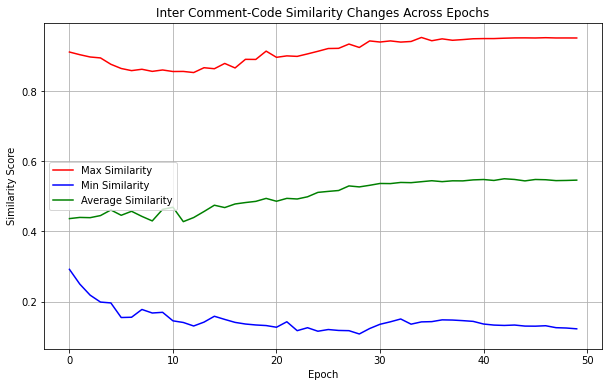


Detailed similarity values across epochs:
Epoch 0:
  Max similarity: 0.9110
  Min similarity: 0.2917
  Average similarity: 0.4363

Epoch 1:
  Max similarity: 0.9034
  Min similarity: 0.2496
  Average similarity: 0.4396

Epoch 2:
  Max similarity: 0.8969
  Min similarity: 0.2181
  Average similarity: 0.4389

Epoch 3:
  Max similarity: 0.8942
  Min similarity: 0.1983
  Average similarity: 0.4449

Epoch 4:
  Max similarity: 0.8761
  Min similarity: 0.1960
  Average similarity: 0.4609

Epoch 5:
  Max similarity: 0.8641
  Min similarity: 0.1544
  Average similarity: 0.4457

Epoch 6:
  Max similarity: 0.8580
  Min similarity: 0.1551
  Average similarity: 0.4571

Epoch 7:
  Max similarity: 0.8619
  Min similarity: 0.1773
  Average similarity: 0.4426

Epoch 8:
  Max similarity: 0.8559
  Min similarity: 0.1672
  Average similarity: 0.4297

Epoch 9:
  Max similarity: 0.8599
  Min similarity: 0.1692
  Average similarity: 0.4626

Epoch 10:
  Max similarity: 0.8555
  Min similarity: 0.1449
  Avera

In [20]:
import matplotlib.pyplot as plt
# 分析并可视化每个epoch的inter comment-code相似度变化
max_sims = []
min_sims = []
avg_sims = []

for sim_matrix in all_inter_comment_code_sims:
    max_sims.append(np.max(sim_matrix))
    min_sims.append(np.min(sim_matrix))
    avg_sims.append(np.mean(sim_matrix))

epochs = range(len(all_inter_comment_code_sims))

plt.figure(figsize=(10, 6))
plt.plot(epochs, max_sims, 'r-', label='Max Similarity')
plt.plot(epochs, min_sims, 'b-', label='Min Similarity')
plt.plot(epochs, avg_sims, 'g-', label='Average Similarity')

plt.xlabel('Epoch')
plt.ylabel('Similarity Score')
plt.title('Inter Comment-Code Similarity Changes Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 打印具体数值
print("\nDetailed similarity values across epochs:")
for epoch in epochs:
    print(f"Epoch {epoch}:")
    print(f"  Max similarity: {max_sims[epoch]:.4f}")
    print(f"  Min similarity: {min_sims[epoch]:.4f}")
    print(f"  Average similarity: {avg_sims[epoch]:.4f}")
    print()



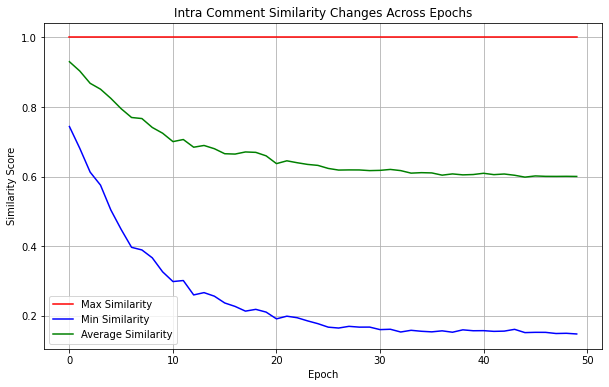


Detailed comment intra similarity values across epochs:
Epoch 0:
  Max similarity: 1.0000
  Min similarity: 0.7439
  Average similarity: 0.9302

Epoch 1:
  Max similarity: 1.0000
  Min similarity: 0.6812
  Average similarity: 0.9035

Epoch 2:
  Max similarity: 1.0000
  Min similarity: 0.6128
  Average similarity: 0.8682

Epoch 3:
  Max similarity: 1.0000
  Min similarity: 0.5755
  Average similarity: 0.8513

Epoch 4:
  Max similarity: 1.0000
  Min similarity: 0.5039
  Average similarity: 0.8249

Epoch 5:
  Max similarity: 1.0000
  Min similarity: 0.4480
  Average similarity: 0.7950

Epoch 6:
  Max similarity: 1.0000
  Min similarity: 0.3966
  Average similarity: 0.7699

Epoch 7:
  Max similarity: 1.0000
  Min similarity: 0.3891
  Average similarity: 0.7669

Epoch 8:
  Max similarity: 1.0000
  Min similarity: 0.3665
  Average similarity: 0.7413

Epoch 9:
  Max similarity: 1.0000
  Min similarity: 0.3262
  Average similarity: 0.7247

Epoch 10:
  Max similarity: 1.0000
  Min similarity: 

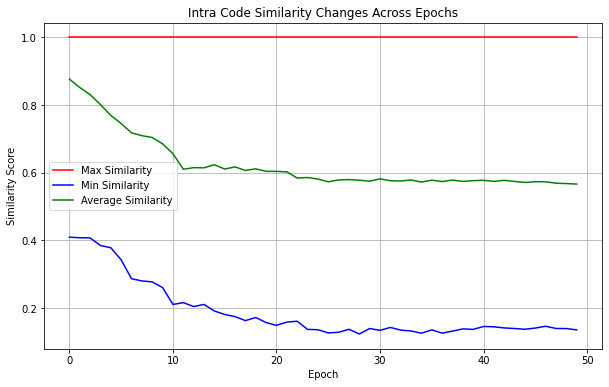


Detailed code intra similarity values across epochs:
Epoch 0:
  Max similarity: 1.0000
  Min similarity: 0.4093
  Average similarity: 0.8768

Epoch 1:
  Max similarity: 1.0000
  Min similarity: 0.4077
  Average similarity: 0.8519

Epoch 2:
  Max similarity: 1.0000
  Min similarity: 0.4072
  Average similarity: 0.8310

Epoch 3:
  Max similarity: 1.0000
  Min similarity: 0.3847
  Average similarity: 0.8013

Epoch 4:
  Max similarity: 1.0000
  Min similarity: 0.3782
  Average similarity: 0.7695

Epoch 5:
  Max similarity: 1.0000
  Min similarity: 0.3420
  Average similarity: 0.7454

Epoch 6:
  Max similarity: 1.0000
  Min similarity: 0.2865
  Average similarity: 0.7178

Epoch 7:
  Max similarity: 1.0000
  Min similarity: 0.2800
  Average similarity: 0.7096

Epoch 8:
  Max similarity: 1.0000
  Min similarity: 0.2772
  Average similarity: 0.7042

Epoch 9:
  Max similarity: 1.0000
  Min similarity: 0.2603
  Average similarity: 0.6853

Epoch 10:
  Max similarity: 1.0000
  Min similarity: 0.2

In [21]:
# 分析并可视化每个epoch的comment intra相似度变化
comment_intra_max_sims = []
comment_intra_min_sims = []
comment_intra_avg_sims = []

for sim_matrix in all_intra_comment_sims:
    comment_intra_max_sims.append(np.max(sim_matrix))
    comment_intra_min_sims.append(np.min(sim_matrix))
    comment_intra_avg_sims.append(np.mean(sim_matrix))

plt.figure(figsize=(10, 6))
plt.plot(epochs, comment_intra_max_sims, 'r-', label='Max Similarity')
plt.plot(epochs, comment_intra_min_sims, 'b-', label='Min Similarity')
plt.plot(epochs, comment_intra_avg_sims, 'g-', label='Average Similarity')

plt.xlabel('Epoch')
plt.ylabel('Similarity Score')
plt.title('Intra Comment Similarity Changes Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 打印具体数值
print("\nDetailed comment intra similarity values across epochs:")
for epoch in epochs:
    print(f"Epoch {epoch}:")
    print(f"  Max similarity: {comment_intra_max_sims[epoch]:.4f}")
    print(f"  Min similarity: {comment_intra_min_sims[epoch]:.4f}")
    print(f"  Average similarity: {comment_intra_avg_sims[epoch]:.4f}")
    print()

# 分析并可视化每个epoch的code intra相似度变化
code_intra_max_sims = []
code_intra_min_sims = []
code_intra_avg_sims = []

for sim_matrix in all_intra_code_sims:
    code_intra_max_sims.append(np.max(sim_matrix))
    code_intra_min_sims.append(np.min(sim_matrix))
    code_intra_avg_sims.append(np.mean(sim_matrix))

plt.figure(figsize=(10, 6))
plt.plot(epochs, code_intra_max_sims, 'r-', label='Max Similarity')
plt.plot(epochs, code_intra_min_sims, 'b-', label='Min Similarity')
plt.plot(epochs, code_intra_avg_sims, 'g-', label='Average Similarity')

plt.xlabel('Epoch')
plt.ylabel('Similarity Score')
plt.title('Intra Code Similarity Changes Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 打印具体数值
print("\nDetailed code intra similarity values across epochs:")
for epoch in epochs:
    print(f"Epoch {epoch}:")
    print(f"  Max similarity: {code_intra_max_sims[epoch]:.4f}")
    print(f"  Min similarity: {code_intra_min_sims[epoch]:.4f}")
    print(f"  Average similarity: {code_intra_avg_sims[epoch]:.4f}")
    print()


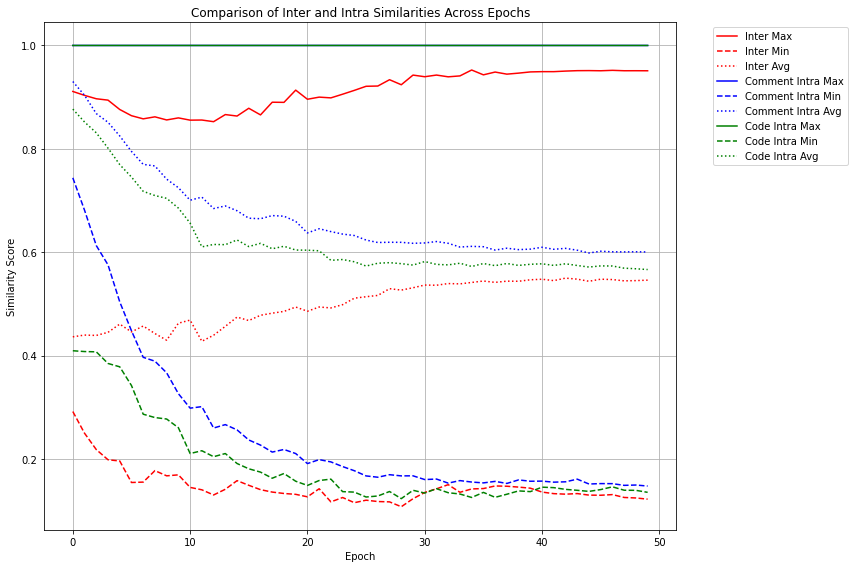


Detailed comparison of similarities across epochs:
Epoch 0:
  Inter similarities:
    Max: 0.9110
    Min: 0.2917
    Avg: 0.4363
  Comment intra similarities:
    Max: 1.0000
    Min: 0.7439
    Avg: 0.9302
  Code intra similarities:
    Max: 1.0000
    Min: 0.4093
    Avg: 0.8768

Epoch 1:
  Inter similarities:
    Max: 0.9034
    Min: 0.2496
    Avg: 0.4396
  Comment intra similarities:
    Max: 1.0000
    Min: 0.6812
    Avg: 0.9035
  Code intra similarities:
    Max: 1.0000
    Min: 0.4077
    Avg: 0.8519

Epoch 2:
  Inter similarities:
    Max: 0.8969
    Min: 0.2181
    Avg: 0.4389
  Comment intra similarities:
    Max: 1.0000
    Min: 0.6128
    Avg: 0.8682
  Code intra similarities:
    Max: 1.0000
    Min: 0.4072
    Avg: 0.8310

Epoch 3:
  Inter similarities:
    Max: 0.8942
    Min: 0.1983
    Avg: 0.4449
  Comment intra similarities:
    Max: 1.0000
    Min: 0.5755
    Avg: 0.8513
  Code intra similarities:
    Max: 1.0000
    Min: 0.3847
    Avg: 0.8013

Epoch 4:
  Inter

In [22]:
# 在同一张图中绘制inter和两个intra的相似度变化（最大值、最小值和平均值）
plt.figure(figsize=(12, 8))

# Inter similarities
plt.plot(epochs, max_sims, 'r-', label='Inter Max')
plt.plot(epochs, min_sims, 'r--', label='Inter Min')
plt.plot(epochs, avg_sims, 'r:', label='Inter Avg')

# Comment intra similarities
plt.plot(epochs, comment_intra_max_sims, 'b-', label='Comment Intra Max')
plt.plot(epochs, comment_intra_min_sims, 'b--', label='Comment Intra Min')
plt.plot(epochs, comment_intra_avg_sims, 'b:', label='Comment Intra Avg')

# Code intra similarities
plt.plot(epochs, code_intra_max_sims, 'g-', label='Code Intra Max')
plt.plot(epochs, code_intra_min_sims, 'g--', label='Code Intra Min')
plt.plot(epochs, code_intra_avg_sims, 'g:', label='Code Intra Avg')

plt.xlabel('Epoch')
plt.ylabel('Similarity Score')
plt.title('Comparison of Inter and Intra Similarities Across Epochs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 打印具体数值对比
print("\nDetailed comparison of similarities across epochs:")
for epoch in epochs:
    print(f"Epoch {epoch}:")
    print("  Inter similarities:")
    print(f"    Max: {max_sims[epoch]:.4f}")
    print(f"    Min: {min_sims[epoch]:.4f}")
    print(f"    Avg: {avg_sims[epoch]:.4f}")
    print("  Comment intra similarities:")
    print(f"    Max: {comment_intra_max_sims[epoch]:.4f}")
    print(f"    Min: {comment_intra_min_sims[epoch]:.4f}")
    print(f"    Avg: {comment_intra_avg_sims[epoch]:.4f}")
    print("  Code intra similarities:")
    print(f"    Max: {code_intra_max_sims[epoch]:.4f}")
    print(f"    Min: {code_intra_min_sims[epoch]:.4f}")
    print(f"    Avg: {code_intra_avg_sims[epoch]:.4f}")
    print()



In [23]:
# 假设我们有一个index是在拼接后的数据中的位置
concatenated_index = 9228  # 这只是一个示例索引

# 获取原始位置的计算方法
original_index = concatenated_index % comment_length

print(f"在拼接数据中的索引 {concatenated_index} 对应原始数据中的索引 {original_index}")

# 验证是否在第一部分还是第二部分
if concatenated_index < comment_length:
    print("这个索引在第一部分数据中")
else:
    print("这个索引在第二部分数据中")


在拼接数据中的索引 9228 对应原始数据中的索引 3507
这个索引在第二部分数据中


Top 10 samples with most neighbor changes:

Index | Total Unique Neighbors
------------------------------
 1559 |                   97
 3093 |                   96
 2124 |                   94
 1358 |                   92
 2189 |                   92
 5034 |                   91
 4250 |                   91
  286 |                   91
  311 |                   88
  195 |                   86


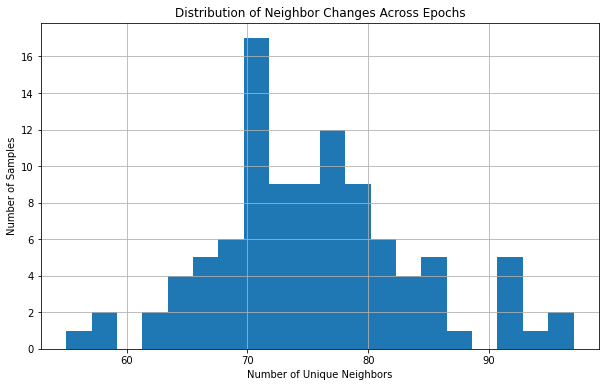

In [24]:
# 随机选择100个样本
sample_size = 100
k = 15  # top-k近邻数量

# 随机选择的索引
random_indices = np.random.choice(comment_length, size=sample_size, replace=False)

# 存储每个样本的邻居变化信息
neighbor_changes = {}

# 对每个随机选择的样本
for target_idx in random_indices:
    # 收集所有epoch中出现过的邻居
    all_neighbors = set()
    epoch_neighbors = {}
    
    # 遍历每个epoch
    for epoch in epochs:
        # 获取该样本在当前epoch的相似度
        similarities = all_inter_comment_code_sims[epoch][target_idx]
        # 获取top-k个最相似邻居的索引
        neighbor_indices = np.argsort(similarities)[-k:][::-1]
        # 存储当前epoch的邻居
        epoch_neighbors[epoch] = set(neighbor_indices)
        # 更新所有出现过的邻居集合
        all_neighbors.update(neighbor_indices)
    
    # 计算邻居变化程度
    total_unique_neighbors = len(all_neighbors)
    neighbor_changes[target_idx] = total_unique_neighbors

# 按变化程度排序
sorted_changes = sorted(neighbor_changes.items(), key=lambda x: x[1], reverse=True)

# 打印变化最剧烈的前10个样本
print("Top 10 samples with most neighbor changes:")
print("\nIndex | Total Unique Neighbors")
print("-" * 30)
for idx, changes in sorted_changes[:10]:
    print(f"{idx:5d} | {changes:20d}")

# 绘制变化分布直方图
plt.figure(figsize=(10, 6))
plt.hist([changes for _, changes in neighbor_changes.items()], bins=20)
plt.xlabel('Number of Unique Neighbors')
plt.ylabel('Number of Samples')
plt.title('Distribution of Neighbor Changes Across Epochs')
plt.grid(True)
plt.show()


In [30]:
# 分析特定index的inter neighbors坐标变化
import time
import os
from IPython.display import clear_output

target_index = 1286
k = 15  # 选择top-k个最相似的邻居

for epoch in epochs:
    # 清除之前的输出
    clear_output(wait=True)
    
    print(f"\n\n\nAnalyzing inter neighbors movement for index \033[1m{target_index}\033[0m:")
    
    # 获取该index在当前epoch的相似度
    similarities = all_inter_comment_code_sims[epoch][target_index]
    # 获取top-k个最相似的邻居的索引
    neighbor_indices = np.argsort(similarities)[-k:][::-1]
    
    print(f"\nEpoch {epoch + 1} neighbors:")
    for neighbor in neighbor_indices:
        # 获取原始位置
        original_pos = neighbor % comment_length
        similarity = similarities[neighbor]
        # Split the f-string to avoid backslash in expression
        if neighbor != target_index:
            print(f"  Neighbor {neighbor} similarity: {similarity:.4f}")
        else:
            print(f"  Neighbor \033[91m{target_index}\033[0m similarity: {similarity:.4f}")
            
    time.sleep(0.8)  # 暂停0.8秒





Analyzing inter neighbors movement for index 1286:

Epoch 50 neighbors:
  Neighbor 2709 similarity: 0.7662
  Neighbor 5108 similarity: 0.7530
  Neighbor 834 similarity: 0.7437
  Neighbor 2125 similarity: 0.7418
  Neighbor 5128 similarity: 0.7394
  Neighbor 1247 similarity: 0.7374
  Neighbor 5567 similarity: 0.7361
  Neighbor 5219 similarity: 0.7361
  Neighbor 3099 similarity: 0.7330
  Neighbor 1316 similarity: 0.7328
  Neighbor 508 similarity: 0.7321
  Neighbor 4091 similarity: 0.7319
  Neighbor 664 similarity: 0.7302
  Neighbor 3084 similarity: 0.7297
  Neighbor 4257 similarity: 0.7283


Analyzing similarities for target_index 1286

Epoch 1:
Self similarity: 0.4077
Max similarity with others: 0.8947
10th highest similarity: 0.5616

Epoch 2:
Self similarity: 0.4229
Max similarity with others: 0.8865
10th highest similarity: 0.5716

Epoch 3:
Self similarity: 0.4452
Max similarity with others: 0.8703
10th highest similarity: 0.5720

Epoch 4:
Self similarity: 0.4541
Max similarity with others: 0.8533
10th highest similarity: 0.5845

Epoch 5:
Self similarity: 0.4648
Max similarity with others: 0.8311
10th highest similarity: 0.6090

Epoch 6:
Self similarity: 0.4619
Max similarity with others: 0.8039
10th highest similarity: 0.6014

Epoch 7:
Self similarity: 0.4739
Max similarity with others: 0.7788
10th highest similarity: 0.6262

Epoch 8:
Self similarity: 0.4361
Max similarity with others: 0.7671
10th highest similarity: 0.5972

Epoch 9:
Self similarity: 0.4211
Max similarity with others: 0.7292
10th highest similarity: 0.5861

Epoch 10:
Self similarity: 0.4579
Max similar

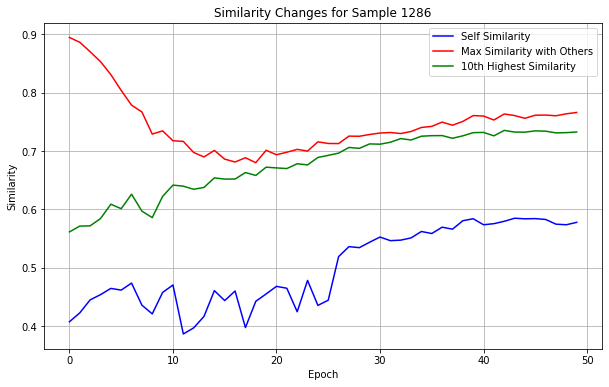

In [31]:
# 获取目标样本的自相似度和与其他样本的最大相似度
self_sims = []
max_other_sims = []
tenth_sims = []

print("Analyzing similarities for target_index", target_index)
for epoch in epochs:
    # 获取当前epoch的相似度
    curr_sims = all_inter_comment_code_sims[epoch][target_index]
    
    # 获取自相似度
    self_sim = curr_sims[target_index]
    self_sims.append(self_sim)
    
    # 获取与其他样本的最大相似度
    other_sims = np.delete(curr_sims, target_index)  # 删除自相似度
    max_other_sim = np.max(other_sims)
    max_other_sims.append(max_other_sim)
    
    # 获取第10名的相似度
    sorted_sims = np.sort(other_sims)[::-1]  # 降序排序
    tenth_sim = sorted_sims[9]  # 第10名
    tenth_sims.append(tenth_sim)
    
    print(f"\nEpoch {epoch + 1}:")
    print(f"Self similarity: {self_sim:.4f}")
    print(f"Max similarity with others: {max_other_sim:.4f}")
    print(f"10th highest similarity: {tenth_sim:.4f}")

# 绘制变化趋势图
plt.figure(figsize=(10, 6))
plt.plot(list(epochs), self_sims, 'b-', label='Self Similarity')
plt.plot(list(epochs), max_other_sims, 'r-', label='Max Similarity with Others')
plt.plot(list(epochs), tenth_sims, 'g-', label='10th Highest Similarity')
plt.xlabel('Epoch')
plt.ylabel('Similarity')
plt.title(f'Similarity Changes for Sample {target_index}')
plt.legend()
plt.grid(True)
plt.show()
